In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import time

In [2]:
t1 = time.time()

In [3]:
path = "/Users/niharawarawita/Desktop/MSc Project/Data/EMG_data_collection/combined_stats_nihara.csv"
data = pd.read_csv(path)
data.head()

,participant_id,clothes_id,property_id,property_name,interaction_id,rating,rating_level,rating_level_num,sub_window_num,subwindow_start_time,...,std_z_Hand1,std_AVx_Hand1,std_AVy_Hand1,std_AVz_Hand1,std_AAx_Hand1,std_AAy_Hand1,std_AAz_Hand1,std_AJx_Hand1,std_AJy_Hand1,std_AJz_Hand1
0,19,3,16,softness,119,6,high,3,1,2022-02-13 11:24:11.302,...,0.034045,0.223631,0.400869,0.198252,5.807455,10.633557,4.886320,434.490981,853.585591,445.739808
1,19,3,16,softness,119,6,high,3,2,2022-02-13 11:24:17.266,...,0.034718,0.102369,0.202003,0.215416,2.624330,4.994368,4.763141,163.059962,293.701684,359.806687
2,19,3,16,softness,119,6,high,3,3,2022-02-13 11:24:22.250,...,0.045145,0.190866,0.258466,0.341591,4.035735,7.234644,6.105591,307.386108,462.341199,430.277295
3,19,3,15,flexibility,120,5,medium,2,1,2022-02-13 11:27:08.930,...,0.042501,0.307340,0.676318,0.321149,8.205791,18.275548,7.814122,633.186926,1362.201276,664.974739
4,19,3,15,flexibility,120,5,medium,2,2,2022-02-13 11:27:15.175,...,0.038397,0.308847,0.553856,0.392333,6.602712,17.628923,9.375255,463.766340,1186.051852,711.834698


In [4]:
print(data.property_name.unique())
print(data.property_id.unique())

['softness' 'flexibility' 'smoothness' 'thickness' 'warmth' 'enjoyment']
[16 15 12 13 14 17]


In [5]:
# Initialise the random state
num = random.randint(1, 500)
print(f"The generated random seed is {num}") #347

The generated random seed is 294


## Section A) Physical properties

In [6]:
physical_data = data[data.property_name != 'enjoyment']
physical_data.head()

,participant_id,clothes_id,property_id,property_name,interaction_id,rating,rating_level,rating_level_num,sub_window_num,subwindow_start_time,...,std_z_Hand1,std_AVx_Hand1,std_AVy_Hand1,std_AVz_Hand1,std_AAx_Hand1,std_AAy_Hand1,std_AAz_Hand1,std_AJx_Hand1,std_AJy_Hand1,std_AJz_Hand1
0,19,3,16,softness,119,6,high,3,1,2022-02-13 11:24:11.302,...,0.034045,0.223631,0.400869,0.198252,5.807455,10.633557,4.886320,434.490981,853.585591,445.739808
1,19,3,16,softness,119,6,high,3,2,2022-02-13 11:24:17.266,...,0.034718,0.102369,0.202003,0.215416,2.624330,4.994368,4.763141,163.059962,293.701684,359.806687
2,19,3,16,softness,119,6,high,3,3,2022-02-13 11:24:22.250,...,0.045145,0.190866,0.258466,0.341591,4.035735,7.234644,6.105591,307.386108,462.341199,430.277295
3,19,3,15,flexibility,120,5,medium,2,1,2022-02-13 11:27:08.930,...,0.042501,0.307340,0.676318,0.321149,8.205791,18.275548,7.814122,633.186926,1362.201276,664.974739
4,19,3,15,flexibility,120,5,medium,2,2,2022-02-13 11:27:15.175,...,0.038397,0.308847,0.553856,0.392333,6.602712,17.628923,9.375255,463.766340,1186.051852,711.834698


<AxesSubplot:>

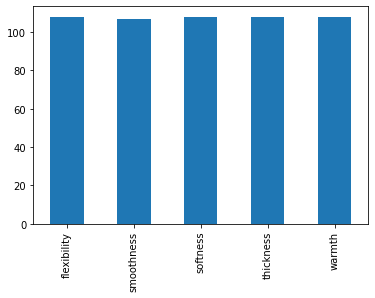

In [7]:
physical_data['property_name'].value_counts().sort_index().plot.bar()

Balanced data. Each property has approximately the same number of samples

<AxesSubplot:>

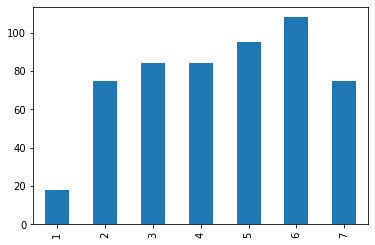

In [8]:
physical_data['rating'].value_counts().sort_index().plot.bar()

Modal answer was 6. Very few people said 1

<AxesSubplot:>

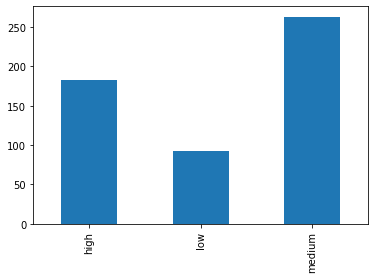

In [9]:
physical_data['rating_level'].value_counts().sort_index().plot.bar()

Unbalanced data. More than double the number of observations for medium than low

### Task 1: Predicting the property based on the provided data (excluding enjoyment data)

#### Step 1: LOCOCV (Leave One Cloth(Sock) Out CV)

In [19]:
# Note: predicting_feature = 'property_id' or 'rating'

def rf_LOCOCV_properties(data, num_inner_folds=5, predicting_feature = 'property_id', random_state=num):
    if predicting_feature == 'property_id':
        print(f'Classification accuracy when predicting properties at random : {round(1/len(data.property_id.unique())*100,2)}% ')
    else:
        print(f'Classification accuracy when predicting ratings at random : {round(1/len(data.rating_level_num.unique())*100,2)}% ')
    print('__________________________________________')
        
    if predicting_feature == 'property_id':
        macro_f1_lst = []
    elif predicting_feature == 'rating_level_num':
        weighted_f1_lst = []    
    micro_f1_lst = []
    acc_lst = []
    for cloth_id in range(1,7):      
        # Split the data into training and testing
        training_data = data[data.clothes_id != cloth_id]
        testing_data = data[data.clothes_id == cloth_id]
        
        # Data preparation
        starting_index = 11
        X_train = training_data.iloc[:,starting_index:].values        
        y_train = training_data[predicting_feature].values
        X_test = testing_data.iloc[:,starting_index:].values        
        y_test = testing_data[predicting_feature].values
        
        # Configure the cross-validation procedure
        cv_inner = KFold(n_splits=num_inner_folds, shuffle=True, random_state=num)
        
        # Define the model
        rf_model = RandomForestClassifier(random_state=num)
        
        # Create a dictionary with the hyperparameters to tune
        features_dict = dict()
        features_dict['n_estimators'] = [100, 500, 1000, 1500]
        
        # Define the Grid Search
        if predicting_feature == 'property_id':
            search = GridSearchCV(rf_model, features_dict, scoring='f1_macro', cv=cv_inner, refit=True) #accuracy
        elif predicting_feature == 'rating_level_num':
            search = GridSearchCV(rf_model, features_dict, scoring='f1_weighted', cv=cv_inner, refit=True) #accuracy
        
        # Execute the search
        result = search.fit(X_train, y_train)    
        
        # Obtain the best performing model fit on the whole training set
        best_rf_model = result.best_estimator_
        
        # Using the model, obtain predictions for the test data
        predictions = best_rf_model.predict(X_test)
        
        # Evaluate the model
        if predicting_feature == 'property_id':
            conf_mat = confusion_matrix(y_test, predictions, labels=[12, 13, 14, 15, 16])
            macro_f1_score = f1_score(y_test, predictions, average='macro') 
            macro_f1_lst.append(macro_f1_score) 
        elif predicting_feature == 'rating_level_num':
            conf_mat = confusion_matrix(y_test, predictions, labels=[1,2,3])
            weighted_f1_score = f1_score(y_test, predictions, average='weighted') 
            weighted_f1_lst.append(weighted_f1_score) 
            
        micro_f1_score = f1_score(y_test, predictions, average='micro')  
        micro_f1_lst.append(micro_f1_score)
        acc = accuracy_score(y_test, predictions)
        acc_lst.append(acc)
        
        print(f'Leaving sock {cloth_id} out {result.best_params_}:') 
        print("(1) Confusion matrix:\n", conf_mat)
        print(f"(2) Micro F1 score = {round(micro_f1_score,2)}")
        if predicting_feature == 'property_id':
            print(f"(3) Macro F1 score = {round(macro_f1_score,2)}")
        elif predicting_feature == 'rating_level_num':
            print(f"(3) Weighted F1 score = {round(weighted_f1_score,2)}")            
        print(f"(4) Percentage Classification accuracy = {round(acc*100,2)}%")

        print('__________________________________________')    

    avg_micro_f1_score = sum(micro_f1_lst) / len(micro_f1_lst)
    if predicting_feature == 'property_id':
        avg_macro_f1_score = sum(macro_f1_lst) / len(macro_f1_lst)
    elif predicting_feature == 'rating_level_num':
        avg_weighted_f1_score = sum(weighted_f1_lst) / len(weighted_f1_lst)               
    avg_acc = sum(acc_lst) / len(acc_lst)   
    
    print(f'Using Leave One Cloth Out CV (LOCOCV):') 
    print(f"(1) Average micro F1 score = {round(avg_micro_f1_score,2)}")
    if predicting_feature == 'property_id':
        print(f"(2) Average macro F1 score = {round(avg_macro_f1_score,2)}")
    elif predicting_feature == 'rating_level_num':
        print(f"(2) Average weighted F1 score = {round(avg_weighted_f1_score,2)}")      
    print(f"(3) Average Percentage Classification accuracy = {round(avg_acc*100,2)}%")


In [11]:
rf_LOCOCV_properties(data=physical_data, num_inner_folds=5, predicting_feature = 'property_id', random_state=num) 


Classification accuracy when predicting properties at random : 20.0% 
__________________________________________
Leaving sock 1 out {'n_estimators': 1500}:
(1) Confusion matrix:
 [[ 6  4  3  1  3]
 [ 2 10  2  2  2]
 [ 3  5  7  2  1]
 [ 2  2  1 10  3]
 [ 6  2  3  7  0]]
(2) Micro F1 score = 0.37
(3) Macro F1 score = 0.35
(4) Percentage Classification accuracy = 37.08%
__________________________________________
Leaving sock 2 out {'n_estimators': 100}:
(1) Confusion matrix:
 [[ 8  5  0  3  2]
 [ 1 11  1  4  1]
 [ 3  1 10  2  2]
 [ 3  2  0 12  1]
 [10  2  3  0  3]]
(2) Micro F1 score = 0.49
(3) Macro F1 score = 0.48
(4) Percentage Classification accuracy = 48.89%
__________________________________________
Leaving sock 3 out {'n_estimators': 100}:
(1) Confusion matrix:
 [[13  2  0  0  3]
 [ 1  8  1  3  5]
 [ 4  5  7  2  0]
 [ 1  1  5  8  3]
 [ 8  3  4  1  2]]
(2) Micro F1 score = 0.42
(3) Macro F1 score = 0.41
(4) Percentage Classification accuracy = 42.22%
________________________________

#### Step 2: LOPOCV (Leave One Participant Out CV)

In [20]:
# Note: predicting_feature = 'property_id' or 'rating'

def rf_LOPOCV_properties(data, num_inner_folds=5, predicting_feature = 'property_id', random_state=num):
    if predicting_feature == 'property_id':
        print(f'Classification accuracy when predicting properties at random : {round(1/len(data.property_id.unique())*100,2)}% ')
    else:
        print(f'Classification accuracy when predicting ratings at random : {round(1/len(data.rating_level_num.unique())*100,2)}% ')
    print('__________________________________________')

    if predicting_feature == 'property_id':
        macro_f1_lst = []
    elif predicting_feature == 'rating_level_num':
        weighted_f1_lst = []    
    micro_f1_lst = []
    acc_lst = []
    
    for participant in range(19,26):    
        if participant == 20:
            pass
        else:
            # Split the data into training and testing
            training_data = data[data.participant_id != participant]
            testing_data = data[data.participant_id == participant]

            # Data preparation
            starting_index = 11
            X_train = training_data.iloc[:,starting_index:].values        
            y_train = training_data[predicting_feature].values
            X_test = testing_data.iloc[:,starting_index:].values        
            y_test = testing_data[predicting_feature].values

            # Configure the cross-validation procedure
            cv_inner = KFold(n_splits=num_inner_folds, shuffle=True, random_state=num)

            # Define the model
            rf_model = RandomForestClassifier(random_state=num)

            # Create a dictionary with the hyperparameters to tune
            features_dict = dict()
            features_dict['n_estimators'] = [100, 500, 1000, 1500]

            # Define the Grid Search
            if predicting_feature == 'property_id':
                search = GridSearchCV(rf_model, features_dict, scoring='f1_macro', cv=cv_inner, refit=True) #accuracy
            elif predicting_feature == 'rating_level_num':
                search = GridSearchCV(rf_model, features_dict, scoring='f1_weighted', cv=cv_inner, refit=True) #accuracy
            #search = GridSearchCV(rf_model, features_dict, scoring='f1_macro', cv=cv_inner, refit=True) #accuracy

            # Execute the search
            result = search.fit(X_train, y_train)

            # Obtain the best performing model fit on the whole training set
            best_rf_model = result.best_estimator_

            # Using the model, obtain predictions for the test data
            predictions = best_rf_model.predict(X_test)

            # Evaluate the model
            if predicting_feature == 'property_id':
                conf_mat = confusion_matrix(y_test, predictions, labels=[12, 13, 14, 15, 16])
                macro_f1_score = f1_score(y_test, predictions, average='macro') 
                macro_f1_lst.append(macro_f1_score) 
            elif predicting_feature == 'rating_level_num':
                conf_mat = confusion_matrix(y_test, predictions, labels=[1,2,3])
                weighted_f1_score = f1_score(y_test, predictions, average='weighted') 
                weighted_f1_lst.append(weighted_f1_score) 
                
            micro_f1_score = f1_score(y_test, predictions, average='micro')  
            micro_f1_lst.append(micro_f1_score)
            acc = accuracy_score(y_test, predictions)
            acc_lst.append(acc)

            print(f'Leaving participant {participant} out {result.best_params_}:') 
            print("(1) Confusion matrix:\n", conf_mat)
            print(f"(2) Micro F1 score = {round(micro_f1_score,2)}")
            if predicting_feature == 'property_id':
                print(f"(3) Macro F1 score = {round(macro_f1_score,2)}")
            elif predicting_feature == 'rating_level_num':
                print(f"(3) Weighted F1 score = {round(weighted_f1_score,2)}")            
            print(f"(4) Percentage Classification accuracy = {round(acc*100,2)}%")

            print('__________________________________________')
    
    avg_micro_f1_score = sum(micro_f1_lst) / len(micro_f1_lst)
    if predicting_feature == 'property_id':
        avg_macro_f1_score = sum(macro_f1_lst) / len(macro_f1_lst)
    elif predicting_feature == 'rating_level_num':
        avg_weighted_f1_score = sum(weighted_f1_lst) / len(weighted_f1_lst)               
    avg_acc = sum(acc_lst) / len(acc_lst)   
    
    print(f'Using Leave One Participant Out CV (LOPOCV):') 
    print(f"(1) Average micro F1 score = {round(avg_micro_f1_score,2)}")
    if predicting_feature == 'property_id':
        print(f"(2) Average macro F1 score = {round(avg_macro_f1_score,2)}")
    elif predicting_feature == 'rating_level_num':
        print(f"(2) Average weighted F1 score = {round(avg_weighted_f1_score,2)}")      
    print(f"(3) Average Percentage Classification accuracy = {round(avg_acc*100,2)}%")
            

In [13]:
rf_LOPOCV_properties(data=physical_data, num_inner_folds=5, predicting_feature = 'property_id', random_state=num) 


Classification accuracy when predicting properties at random : 20.0% 
__________________________________________
Leaving participant 19 out {'n_estimators': 1500}:
(1) Confusion matrix:
 [[ 2  8  1  7  0]
 [ 0  5  0 13  0]
 [ 0  2  2 13  1]
 [ 0  0  2 16  0]
 [ 2  7  0  8  1]]
(2) Micro F1 score = 0.29
(3) Macro F1 score = 0.23
(4) Percentage Classification accuracy = 28.89%
__________________________________________
Leaving participant 21 out {'n_estimators': 1500}:
(1) Confusion matrix:
 [[15  0  0  2  1]
 [14  1  0  2  1]
 [ 6  0  0 10  2]
 [ 6  0  1  3  8]
 [14  0  0  1  3]]
(2) Micro F1 score = 0.24
(3) Macro F1 score = 0.17
(4) Percentage Classification accuracy = 24.44%
__________________________________________
Leaving participant 22 out {'n_estimators': 1000}:
(1) Confusion matrix:
 [[ 2 11  0  2  3]
 [ 1 10  3  2  2]
 [ 0  8  3  6  1]
 [ 2  4  1  8  3]
 [ 3  5  0  6  4]]
(2) Micro F1 score = 0.3
(3) Macro F1 score = 0.28
(4) Percentage Classification accuracy = 30.0%
________

### Task 2: Predicting the rating of the property based on the data

#### Step 1: LOCOCV (Leave One Cloth(Sock) Out CV)

In [14]:
def rf_LOCOCV_rating(data, num_inner_folds=5, predicting_feature = 'rating_level_num', random_state=num):
    lst = ['smoothness', 'thickness', 'warmth', 'flexibility', 'softness']
    for prop in lst:
        # Create dataset
        property_data = data[data.property_name == prop]
        
        print(f"For {prop}:")
        rf_LOCOCV_properties(data=property_data, num_inner_folds=5, predicting_feature = 'rating_level_num', random_state=num)
        print('____________________________________________________________________________________')
        

In [21]:
rf_LOCOCV_rating(data=physical_data, num_inner_folds=5, predicting_feature = 'rating_level_num', random_state=num)
    

For smoothness:
Classification accuracy when predicting ratings at random : 33.33% 
__________________________________________
Leaving sock 1 out {'n_estimators': 500}:
(1) Confusion matrix:
 [[0 6 0]
 [0 7 1]
 [0 3 0]]
(2) Micro F1 score = 0.41
(3) Weighted F1 score = 0.27
(4) Percentage Classification accuracy = 41.18%
__________________________________________
Leaving sock 2 out {'n_estimators': 100}:
(1) Confusion matrix:
 [[ 0 11  1]
 [ 0  6  0]
 [ 0  0  0]]
(2) Micro F1 score = 0.33
(3) Weighted F1 score = 0.17
(4) Percentage Classification accuracy = 33.33%
__________________________________________
Leaving sock 3 out {'n_estimators': 500}:
(1) Confusion matrix:
 [[0 3 0]
 [3 3 0]
 [0 9 0]]
(2) Micro F1 score = 0.17
(3) Weighted F1 score = 0.1
(4) Percentage Classification accuracy = 16.67%
__________________________________________
Leaving sock 4 out {'n_estimators': 100}:
(1) Confusion matrix:
 [[ 0  1  2]
 [ 2 13  0]
 [ 0  0  0]]
(2) Micro F1 score = 0.72
(3) Weighted F1 scor

#### Step 2: LOPOCV (Leave One Participant Out CV)

In [16]:
def rf_LOPOCV_rating(data, num_inner_folds=5, predicting_feature = 'rating_level_num', random_state=num):
    lst = ['smoothness', 'thickness', 'warmth', 'flexibility', 'softness']#, 'enjoyment']
    #print(f'Classification accuracy when predicting properties at random: {round((1/7)*100,2)}% ')
    for prop in lst:
        # Create dataset
        property_data = data[data.property_name == prop]
        
        print(f"For {prop}:")
        rf_LOPOCV_properties(data=property_data, num_inner_folds=5, predicting_feature = 'rating_level_num', random_state=num)
        print('____________________________________________________________________________________')
        

In [18]:
rf_LOPOCV_rating(data=physical_data, num_inner_folds=5, predicting_feature = 'rating_level_num', random_state=num)


For smoothness:
Classification accuracy when predicting ratings at random : 14.29% 
__________________________________________
Leaving participant 19 out {'n_estimators': 1500}:
(1) Confusion matrix:
 [[0 5 1]
 [1 5 6]
 [0 0 0]]
(2) Micro F1 score = 0.28
(3) Weighted F1 score = 0.3
(4) Percentage Classification accuracy = 27.78%
__________________________________________
Leaving participant 21 out {'n_estimators': 100}:
(1) Confusion matrix:
 [[ 0  6  0]
 [ 0 12  0]
 [ 0  0  0]]
(2) Micro F1 score = 0.67
(3) Weighted F1 score = 0.53
(4) Percentage Classification accuracy = 66.67%
__________________________________________
Leaving participant 22 out {'n_estimators': 500}:
(1) Confusion matrix:
 [[0 6 0]
 [0 3 0]
 [0 9 0]]
(2) Micro F1 score = 0.17
(3) Weighted F1 score = 0.05
(4) Percentage Classification accuracy = 16.67%
__________________________________________
Leaving participant 23 out {'n_estimators': 1000}:
(1) Confusion matrix:
 [[ 0  0  0]
 [ 4 11  0]
 [ 0  3  0]]
(2) Micro F1

In [ ]:
t2 = time.time()
print(t2 -t1)

In [ ]:
fchjgvkhlj

## Section B) Affective properties - Enjoyment

### Task 1: Predicting the property based on the provided data (including enjoyment data)

#### Step 1: Basic implementation, without CV

In [ ]:
rf_properties(data, random_state=num)    

#### Step 2: LOCOCV (Leave One Cloth(Sock) Out CV)

### Task 2: Predicting the rating of the property based on the data

In [ ]:
enjoyment_data = data[data.property_name == 'enjoyment']

In [ ]:
def rf_rating_enjoyment(data, random_state = num):
    print(f'Classification accuracy when predicting properties at random: {round((1/7)*100,2)}% ')

    # Data preparation
    y_property = data['rating'].values
    X_property = data.iloc[:,9:].values

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_property, y_property, test_size = 0.3, shuffle=True, random_state = num) 

    # Instantiate model with 1000 decision trees
    rf_model = RandomForestClassifier(n_estimators = 1000, random_state = num) 

    # Train the model on the training data
    rf_model.fit(X_train, y_train)

    # Using the model, obtain predictions for the test data
    predictions = rf_model.predict(X_test)

    # Calculate the number of correct predictions
    acc = accuracy_score(y_test, predictions)   

    # Print out the percentage classification accuracy for the test set
    print(f'Classification accuracy for the test set when predicting the rating for enjoyment: {round(acc*100,2)}%')

rf_rating_enjoyment(enjoyment_data)
     

In [ ]:
t2 = time.time()
t2 - t1

In [ ]:
gjvhkbjln

def rf_properties(data, random_state=num): #drop=None, 
    print(f'Classification accuracy when predicting properties at random : {round(1/len(data.property_id.unique())*100,2)}% ')

    # Data preparation
    y = data['property_id'].values
    starting_index = 10
    X = data.iloc[:,starting_index:].values

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=True, random_state = num) 

    # Instantiate model with 1000 decision trees
    rf_model = RandomForestClassifier(n_estimators = 1000, random_state = num) 

    # Train the model on the training data
    rf_model.fit(X_train, y_train)

    # Using the model, obtain predictions for the test data
    predictions = rf_model.predict(X_test)

    # Evaluate the model
    conf_mat = confusion_matrix(y_test, predictions, labels=[12, 13, 14, 15, 16])
    f1_score_val = f1_score(y_test, predictions, average=None)
    avg_f1_score = sum(f1_score_val) / len(f1_score_val)
    acc = accuracy_score(y_test, predictions)

    print('Metrics that evaluate the classification accuracy of the random forest:') 
    print("(1) Confusion matrix:\n", conf_mat)
    print(f"(2) F1 score = {round(avg_f1_score,2)}")
    print(f"(3) Percentage Classification accuracy = {round(acc*100,2)}%")

rf_properties(data=physical_data, random_state=num)  

def rf_rating(data, random_state = num):
    lst = ['smoothness', 'thickness', 'warmth', 'flexibility', 'softness']#, 'enjoyment']
    print(f'Classification accuracy when predicting properties at random: {round((1/7)*100,2)}% ')
    print('__________________________________________')
    
    for prop in lst:
        # Create dataset
        property_data = data[data.property_name == prop]
        
        # Data preparation
        starting_index = 10
        X_property = property_data.iloc[:,starting_index:].values
        y_property = property_data['rating'].values

        
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_property, y_property, test_size = 0.3, shuffle=True, random_state = num) 

        # Instantiate model with 1000 decision trees
        rf_model = RandomForestClassifier(n_estimators = 1000, random_state = num) 

        # Train the model on the training data
        rf_model.fit(X_train, y_train)
        
        # Using the model, obtain predictions for the test data
        predictions = rf_model.predict(X_test)

        # Evaluate the model
        conf_mat = confusion_matrix(y_test, predictions, labels=[1, 2, 3, 4, 5, 6, 7])
        f1_score_val = f1_score(y_test, predictions, average=None)
        avg_f1_score = sum(f1_score_val) / len(f1_score_val)
        acc = accuracy_score(y_test, predictions)

        # Print out the percentage classification accuracy for the test set
       # print(f'Classification accuracy for the test set when predicting the rating for {prop}: {round(acc*100,2)}%')
        print(f'Metrics that evaluate the classification accuracy of the random forest for property {prop}:') 
        print("(1) Confusion matrix:\n", conf_mat)
        print(f"(2) F1 score = {round(avg_f1_score,2)}")
        print(f"(3) Percentage Classification accuracy = {round(acc*100,2)}%")


        print('__________________________________________')


rf_rating(data=physical_data)


#### First, consider only the physical properties

In [ ]:
print(data.shape)
data = data[data.property_name != 'enjoyment']
print(data.shape)

In [ ]:
# manual nested cross-validation for random forest on a classification dataset
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# create dataset
X, y = make_classification(n_samples=1000, n_features=20, random_state=1, n_informative=10, n_redundant=10)
# configure the cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# enumerate splits
num_inner_folds = 5
outer_results = list()
for train_ix, test_ix in cv_outer.split(X):
    # split data
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]
    # configure the cross-validation procedure
    cv_inner = KFold(n_splits=num_inner_folds, shuffle=True, random_state=num)
    # define the model
    model = RandomForestClassifier(random_state=num)
    # define search space
    space = dict()
    space['n_estimators'] = [10, 100, 500, 1000]
    # define search
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True) #accuracy
    # execute search
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))